# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

After which we collect the words used to describe positive and negative reviews

In [20]:
## Similartly you can do preprocessing for review summary also.
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [21]:
if os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    final_string_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
        
    for sent in tqdm(final['Summary'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        
                    else:
                        continue
                else:
                    continue 
        str2 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string_summary.append(str2)
        i+=1
        
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    
    final['CleanedSummary']=final_string_summary
    final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:51<00:00, 7029.23it/s]


In [22]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...,love book miss hard cover version
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...,chicken soup rice month
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...,good swingi rhythm read aloud
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...,great way learn month


In [23]:
with open('final.pkl', 'wb') as f:
        pickle.dump(final, f)

In [30]:
with open('final.pkl', 'rb') as f:
        final=pickle.load(f)

In [31]:
final=final.sort_values('Time')

In [32]:
final.shape

(364171, 12)

In [33]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [34]:
final['CleanedTextSummary'] = final['CleanedText'] + final['CleanedSummary']

In [35]:
final= final.tail(346000)

In [36]:
final["Score"].value_counts()

1    290862
0     55138
Name: Score, dtype: int64

In [37]:
#fulltrain=final.head(291200)

test=final.tail(103800)

train=final.head(242200)

#cv=final.tail(72800)

In [38]:
#print(fulltrain["Score"].value_counts())
print(train["Score"].value_counts())
#print(cv["Score"].value_counts())
print(test["Score"].value_counts())

1    205153
0     37047
Name: Score, dtype: int64
1    85709
0    18091
Name: Score, dtype: int64


In [39]:
train_scores=train["Score"]
#cv_scores=cv["Score"]
test_scores=test["Score"]

# [4] Featurization

## [4.1] BAG OF WORDS

In [40]:
count_vect = CountVectorizer()#Convert a collection of text documents to a matrix of token counts
train_bow = count_vect.fit_transform(train["CleanedTextSummary"].values)

test_bow = count_vect.transform(test["CleanedTextSummary"].values)
#We use fit_transform() on the train data so that we learn the parameters of scaling on the train data and in the same time we scale the train data.
#We use transform() on the cv & test data because we use the scaling paramaters learned on the train data to scale the test data.

## [4.2] TF-IDF

In [44]:
tfidf_vect = TfidfVectorizer()
train_tfidf = tfidf_vect.fit_transform(train['CleanedTextSummary'].values)
#cv_tf_idf = tf_idf_vect.transform(cv['CleanedText'].values)
test_tfidf = tfidf_vect.transform(test['CleanedTextSummary'].values)
#fulltrain_tf_idf = tf_idf_vect.fit_transform(fulltrain['CleanedText'])

## [4.4] Word2Vec

In [16]:
print("*******train******")
i=0
train_w2v_list=[]
for sent in tqdm(train['CleanedTextSummary'].values):
    train_w2v_list.append(sent.split())

print("*****test******")    
i=0
test_w2v_list=[]
for sent in tqdm(test['CleanedTextSummary'].values):
    test_w2v_list.append(sent.split())    

*******train******


100%|███████████████████████████████████████████████████████████████████████| 242200/242200 [00:03<00:00, 68069.02it/s]


*****test******


100%|███████████████████████████████████████████████████████████████████████| 103800/103800 [00:02<00:00, 48896.18it/s]


In [18]:
#training the train,cv,test data list with the words occuring minimum 5 times 
train_w2v=Word2Vec(train_w2v_list,min_count=5,size=50, workers=2)
#cv_w2v=Word2Vec(cv_w2v_list,min_count=5,size=50, workers=2)
test_w2v=Word2Vec(test_w2v_list,min_count=5,size=50, workers=2)

In [19]:
train_w2v_words = list(train_w2v.wv.vocab)
#cv_w2v_words = list(cv_w2v.wv.vocab)
test_w2v_words = list(test_w2v.wv.vocab)

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [86]:
avg_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_train.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████| 242200/242200 [21:43<00:00, 185.78it/s]


In [87]:
avg_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(test_w2v_list): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avg_w2v_test.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████| 103800/103800 [06:33<00:00, 263.58it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [13]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(train['CleanedTextSummary'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [14]:
model = TfidfVectorizer()
tf_idf_matrix_test = model.fit(test['CleanedTextSummary'].values)
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [20]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names


tfidf_w2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in train_w2v_words:
            vec = train_w2v.wv[word]
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_train.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 242200/242200 [23:33<00:00, 171.38it/s]


In [21]:
tfidf_feat = model.get_feature_names()
tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(test_w2v_list): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in test_w2v_words:
            vec = test_w2v.wv[word]
            tf_idf = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_test.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 103800/103800 [07:38<00:00, 226.34it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

Logistic Regression is a clssification technique. This technique works very good on linearly seperable or almost linearly seperable data. lineraly seperable means the data is seperated via Hyperplane which is drawn between the +1(positive's) and -1(negetive's). For logistic regression we add regularization to avoid the hyperpalne infinte values. 

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [63]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l1')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(train_bow,train_scores)

print(model.best_estimator_)



LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [64]:
print(model.score(test_bow, test_scores))

0.9303660253547155


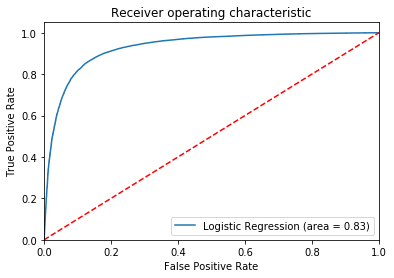

In [66]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR.fit(train_bow, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(test_bow))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(test_bow)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

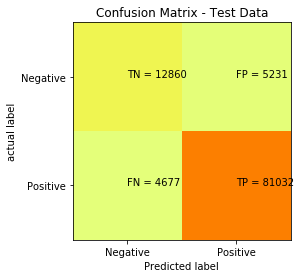

In [67]:
from sklearn.metrics import classification_report

L1_bow_test = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100,\
                                 multi_class='ovr', n_jobs=1,penalty='l1', random_state=None, solver='liblinear', tol=0.0001,\
                                 verbose=0, warm_start=False)

#NB_bow_test = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None)

L1_bow_test.fit(train_bow, train_scores)

pred = L1_bow_test.predict(test_bow)

cnf = confusion_matrix(test_scores, pred)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 93.9
-> the % of correctly predicted negitive's are 73.3

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [46]:
# Please write all the code with proper documentation

clf = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
clf.fit(train_bow, train_scores);
w = clf.coef_
print(np.count_nonzero(w))


9695


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [41]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l2')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(train_bow,train_scores)

print(model.best_estimator_)
print(model.score(test_bow, test_scores))


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9464272249232828


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [42]:
# Please write all the code with proper documentation
LR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(train_bow,train_scores)
W1 = LR.coef_ # returns a matrix of weights (coefficients)

In [43]:
print(W1)

[[0.13267214 0.30226764 0.00939799 ... 0.02943448 0.01199546 0.01301327]]


In [44]:
train_bow_noise = train_bow

In [45]:
train_bow_noise.shape

(242200, 186346)

In [48]:
#train_bow_noise = train_bow
epsilon = np.random.normal(loc=0.0, scale=0.01)
non_zero_index = np.transpose(np.nonzero(train_bow_noise))
for i,j in non_zero_index:
    train_bow_noise[i,j] += epsilon

In [49]:
train_bow_noise.shape

(242200, 186346)

In [50]:
LR.fit(train_bow_noise,train_scores)
W2 = LR.coef_ # returns a matrix of weights (coefficients)

In [54]:
print(np.count_nonzero(W2))

16153


In [55]:
W11 = W1+10**-6
W22 = W2+10**-6

In [56]:

percentage_change_vector = (abs((W11-W22) / (W11) ))*100

In [57]:
print(len(percentage_change_vector))

1


In [58]:
for i in range(0, 101,10):
    print('the',i,'th percentile of the vector:',np.percentile(percentage_change_vector,i))


the 0 th percentile of the vector: 0.0023184585665222187
the 10 th percentile of the vector: 99.0158148628374
the 20 th percentile of the vector: 99.91303926847758
the 30 th percentile of the vector: 99.97696990034608
the 40 th percentile of the vector: 99.99145711238421
the 50 th percentile of the vector: 99.99621427275794
the 60 th percentile of the vector: 99.99832996736782
the 70 th percentile of the vector: 99.99940128403318
the 80 th percentile of the vector: 100.00032355126747
the 90 th percentile of the vector: 100.0028079560771
the 100 th percentile of the vector: 2417364.3525062897


In [62]:
for i in range(0, 10,1):
    print('the',i,'th percentile of the vector:',np.percentile(percentage_change_vector,i))
print("*************************************************************************")
for i in range(90, 100,1):
    print('the',i,'th percentile of the vector:',np.percentile(percentage_change_vector,i))
    
print("*************************************************************************")    
print('the',99.1,'th percentile of the vector:',np.percentile(percentage_change_vector,99.1))
print('the',99.2,'th percentile of the vector:',np.percentile(percentage_change_vector,99.2))
print('the',99.3,'th percentile of the vector:',np.percentile(percentage_change_vector,99.3))
print('the',99.4,'th percentile of the vector:',np.percentile(percentage_change_vector,99.4))
print('the',99.5,'th percentile of the vector:',np.percentile(percentage_change_vector,99.5))
print('the',99.6,'th percentile of the vector:',np.percentile(percentage_change_vector,99.6))
print('the',99.7,'th percentile of the vector:',np.percentile(percentage_change_vector,99.7))
print('the',99.8,'th percentile of the vector:',np.percentile(percentage_change_vector,99.8))
print('the',99.9,'th percentile of the vector:',np.percentile(percentage_change_vector,99.9))
print('the',100,'th percentile of the vector:',np.percentile(percentage_change_vector,100))


the 0 th percentile of the vector: 0.0023184585665222187
the 1 th percentile of the vector: 24.04672628306486
the 2 th percentile of the vector: 46.59608497189042
the 3 th percentile of the vector: 64.07008576500442
the 4 th percentile of the vector: 78.26919955132317
the 5 th percentile of the vector: 88.28992899600308
the 6 th percentile of the vector: 93.6435521453061
the 7 th percentile of the vector: 96.2763854490074
the 8 th percentile of the vector: 97.72339620764416
the 9 th percentile of the vector: 98.54702337445015
*************************************************************************
the 90 th percentile of the vector: 100.0028079560771
the 91 th percentile of the vector: 100.00451127016112
the 92 th percentile of the vector: 100.00822528721939
the 93 th percentile of the vector: 100.01876121379973
the 94 th percentile of the vector: 100.05629074129689
the 95 th percentile of the vector: 100.31221368227729
the 96 th percentile of the vector: 104.42218919014056
the 97 th 

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [41]:
lR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
LR.fit(train_bow,train_scores)
class_labels = LR.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(LR.coef_[0], feature_names))[:10]
topn_class2 = sorted(zip(LR.coef_[0], feature_names))[-10:]

print("top 10 negitive features:")
for coef, feat in topn_class1:
    print (class_labels[0], coef, feat)

top 10 negitive features:
0 -2.756542763431319 worst
0 -2.7556449900339275 weakest
0 -2.742522564487713 undrink
0 -2.477942702734032 unapp
0 -2.456072705411874 compass
0 -2.3934552140968726 buydisappoint
0 -2.263694812014867 disappointdisappoint
0 -2.2235556710954896 unaccept
0 -2.154491654549255 holl
0 -2.1113830479656546 mediocr


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [42]:
# Please write all the code with proper documentation
print("top 10 positive features:")
for coef, feat in reversed(topn_class2):
    print (class_labels[1], coef, feat)

top 10 positive features:
1 2.43306284980738 greatgreat
1 2.318730112838712 skeptic
1 2.2549787078277586 lovelove
1 2.2463700621583036 yay
1 2.2291693984592063 recommendgreat
1 2.1931605981450915 lovegreat
1 2.172092619214982 bestbest
1 2.167835324941456 delicigreat
1 2.1618742518195293 deduct
1 1.990008127054158 goodgreat


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [102]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l1')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(train_tfidf,train_scores)

print(model.best_estimator_)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [103]:
print(model.score(test_tfidf, test_scores))

0.9540312924533502


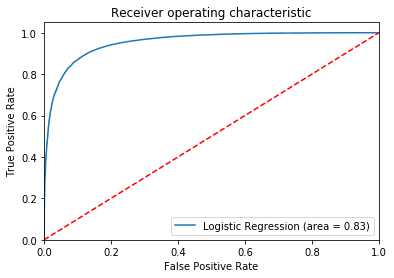

In [104]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(train_tfidf, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(test_tfidf))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(test_tfidf)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

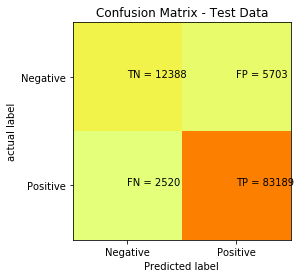

In [105]:
from sklearn.metrics import confusion_matrix


LR.fit(train_tfidf,train_scores)

pred1_tfidf = LR.predict(test_tfidf)

cnf = confusion_matrix(test_scores, pred1_tfidf)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 93.5
-> the % of correctly predicted negitive's are 83.0

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [98]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation

# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l2')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(train_tfidf,train_scores)

print(model.best_estimator_)
print(model.score(test_tfidf, test_scores))


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.955159540819225


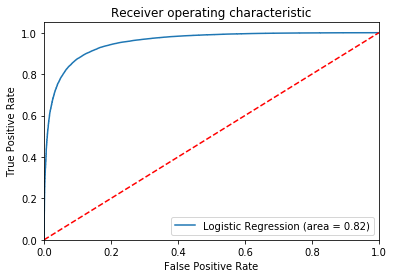

In [99]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(train_tfidf, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(test_tfidf))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(test_tfidf)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

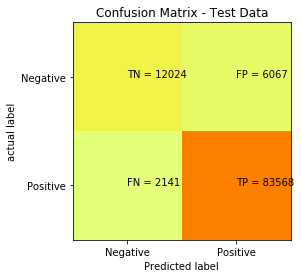

In [101]:
LR.fit(train_tfidf,train_scores)

pred2_tfidf = LR.predict(test_tfidf)

cnf = confusion_matrix(test_scores, pred2_tfidf)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 93.2
-> the % of correctly predicted negitive's are 84.8

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [109]:
# Please write all the code with proper documentation
class_labels = LR.classes_
feature_names = count_vect.get_feature_names()
topn_class1 = sorted(zip(LR.coef_[0], feature_names))[:10]
topn_class2 = sorted(zip(LR.coef_[0], feature_names))[-10:]

print("top 10 negitive features:")
for coef, feat in topn_class1:
    print (class_labels[0], coef, feat)

top 10 negitive features:
0 -16.230497728762387 worst
0 -12.0198688792972 disappoint
0 -10.703397220767355 aw
0 -10.62565415051248 undrink
0 -10.289860025343998 terribl
0 -9.992863851303385 horribl
0 -9.5301135284797 threw
0 -9.20023418890989 tasteless
0 -8.92162513895672 disgust
0 -8.510797121933091 unapp


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [111]:
# Please write all the code with proper documentation
print("top 10 positive features:")
for coef, feat in topn_class2:
    print (class_labels[1], coef, feat)

top 10 positive features:
1 9.581461357312985 awesom
1 10.313093994036102 hook
1 10.805947150496962 amaz
1 11.835947828200348 love
1 11.873517854949489 skeptic
1 12.19104601138165 excel
1 13.220654947621002 perfect
1 13.787288241828426 best
1 15.202004380827411 delici
1 15.97489940793997 great


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [113]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l1')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(avg_w2v_train,train_scores)

print(model.best_estimator_)
print(model.score(avg_w2v_test, test_scores))


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.7562308345277592


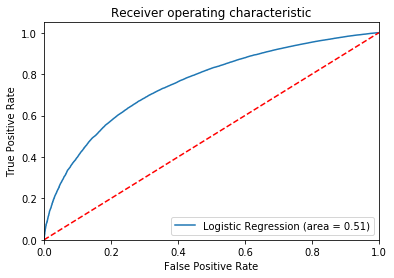

In [114]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(avg_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(avg_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(avg_w2v_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

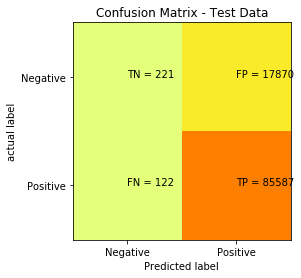

In [115]:
LR.fit(avg_w2v_train,train_scores)

pred1_avg_w2v = LR.predict(avg_w2v_test)

cnf = confusion_matrix(test_scores, pred1_avg_w2v)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 82.7
-> the % of correctly predicted negitive's are 64.4

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [116]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l2')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(avg_w2v_train, train_scores)

print(model.best_estimator_)
print(model.score(avg_w2v_test, test_scores))


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.7490877441928829


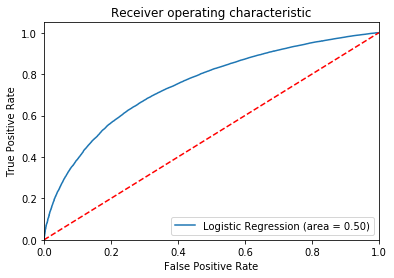

In [117]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(avg_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(avg_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(avg_w2v_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

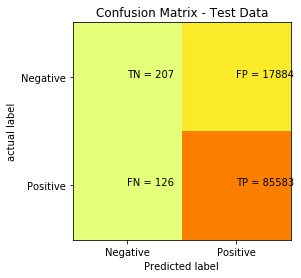

In [118]:

LR.fit(avg_w2v_train, train_scores)

pred2_avg_w2v = LR.predict(avg_w2v_test)

cnf = confusion_matrix(test_scores, pred2_avg_w2v)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 82.7
-> the % of correctly predicted negitive's are 62.1

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV


tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l1')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_w2v_train,train_scores)

print(model.best_estimator_)
print(model.score(tfidf_w2v_test, test_scores))


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6021353490715643


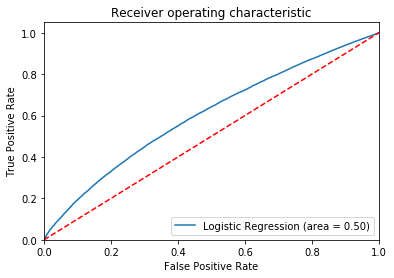

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(tfidf_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(tfidf_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(tfidf_w2v_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

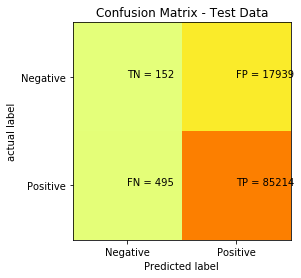

In [25]:
LR.fit(tfidf_w2v_train,train_scores)

pred1_tfidf_w2v = LR.predict(tfidf_w2v_test)

cnf = confusion_matrix(test_scores, pred1_tfidf_w2v)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 82.6
-> the % of correctly predicted negitive's are 23.4

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [26]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
LR = LogisticRegression(penalty='l2')
model = GridSearchCV(LR, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(tfidf_w2v_train,train_scores)

print(model.best_estimator_)
print(model.score(tfidf_w2v_test, test_scores))


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.6001704034936779


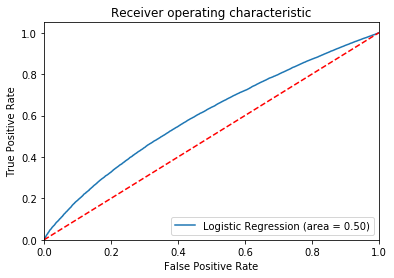

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

LR = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

LR.fit(tfidf_w2v_train, train_scores)

logit_roc_auc = roc_auc_score(test_scores, LR.predict(tfidf_w2v_test))
fpr, tpr, thresholds = roc_curve(test_scores, LR.predict_proba(tfidf_w2v_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

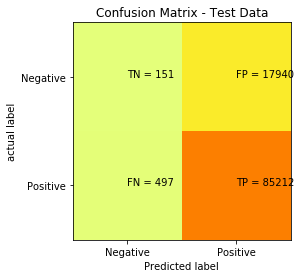

In [28]:
LR.fit(tfidf_w2v_train,train_scores)

pred2_tfidf_w2v = LR.predict(tfidf_w2v_test)

cnf = confusion_matrix(test_scores, pred2_tfidf_w2v)

plt.imshow(cnf, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('actual label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=360)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cnf[i][j]))
plt.show()

Obsesrvation:
-> The % of correctly predicted positive's are 82.6
-> the % of correctly predicted negitive's are 23.3


# [6] Conclusions

*****************************************************
*Featurization | hyperparameter | score | Tpr | Fpr *
*****************************************************
*     BoW      |        1       |  93.0 | 93.9| 73.3*
*****************************************************
*    Tfidf     |        1       |  95.4 | 93.2| 84.8*
*****************************************************
*   avg_w2v    |       100      |  75.0 | 82.7| 64.4*
*****************************************************
*  Tfidf_w2v   |        1       |  60.0 | 82.6| 23.3*
*****************************************************